<a href="https://colab.research.google.com/github/neosavvy/hands-on-deep-learning/blob/master/Integrated_Gradient_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

# **Introduction**

The goal of this colab is to demonstrate how to use integrated gradient to obtain feature importance in image classification tasks.

We will use the same task as Homework 1: to recognize sentiment from a facial image. To that end, we will use the 2013 FER ('Facial Expression Recognition'). The dataset consists of ~ 36,000 images, each annotated with one of seven labels: 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'. 

First, lets start with grabbing the data itself from Dropbox

In [ ]:
from os.path import exists

In [ ]:
if exists('/content/fer2013.csv') == False:  ##if file does not exists, we download it from Dropbox
    !wget -q -P ./ https://www.dropbox.com/s/ia62dg6kpp3q8wb/fer2013.csv

In [ ]:
data = pd.read_csv('/content/fer2013.csv')
print(data.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


As you can see, each (gray-scale) image is encoded as a list of (2304) pixels that we will reshape into an (48x48) image. This keeps the size of the datset manageable. Moreover, each image is associated with an emotion label between 0 and 6 that map repsectively to the emotions 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'. Lets convert these pixel lists into actual images that we can work with next.  

In [ ]:
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # read each face as a 1-d array 
    face = np.asarray(face).reshape(width, height) # reshape the length 2304 1-d array into an 48x48 array
    face = np.stack((face,)*3, axis=-1) # convert single channel to three channels simply by replicating the single channel we have. 
    faces.append(face.astype('float32'))
faces = np.asarray(faces)

emotions = pd.get_dummies(data['emotion']).to_numpy() # each emotion is 'one-hot' encoded as a 7-dim vector
emotions_names = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') 

Lets take a look at some of these fun images! 

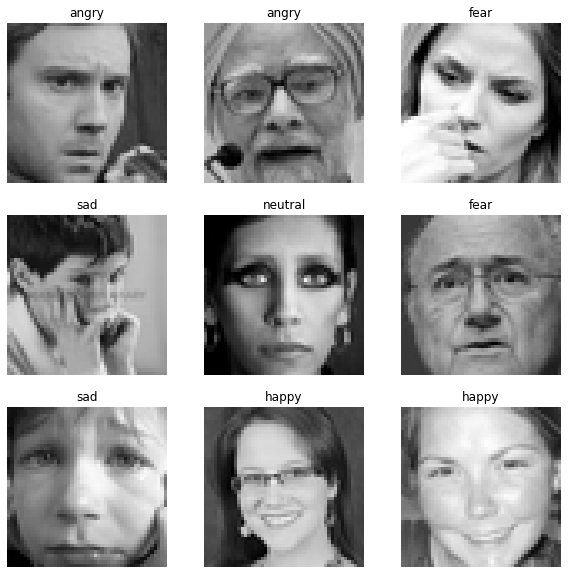

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(f"{emotions_names[np.argmax(emotions[i])]}")
    ax.imshow(faces[i].astype('uint8'))
    ax.axis('off')

As in the original dataset, we will reserve the first 28,709 images for trainingm and the rest for testing. 

In [ ]:
train_faces, train_emotions =  faces[:28709], emotions[:28709]
test_faces, test_emotions =  faces[28709:], emotions[28709:]

In [ ]:
print(train_faces.shape, train_emotions.shape)

(28709, 48, 48, 3) (28709, 7)


In [ ]:
print(test_faces.shape, test_emotions.shape)

(7178, 48, 48, 3) (7178, 7)


# **Constructing a Transfer Learning Model**

**This part is the same as the homework. You should skip it if you are already familiar with this (we already finished the training of the model for you).**

We architect a basic transfer learning model. We will take a slightly different approach from what we saw in class: as opposed to generating feature vectors by running each image through a pre-trained model, we will simply (a) remove the top from an existing pre-trained model, and (b) add a custome designed top. Why are we doing this? Its so that we can 'tweak' the weights of then original pre-trained model to suit our new domain.

Let us start with data augmentation.

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomZoom(0.2),
    ]
)

Lets quickly visualize what an augmentation does ... 

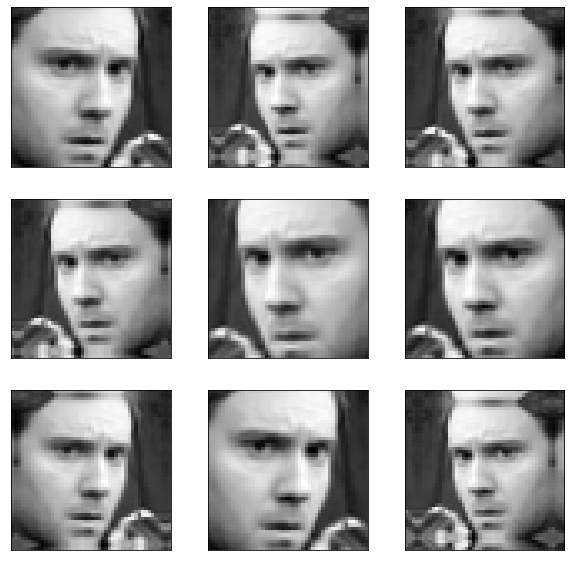

In [ ]:
augmented_images = [data_augmentation(np.expand_dims(train_faces[0],axis=0)) for i in range(9)]
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(tf.keras.preprocessing.image.array_to_img(augmented_images[i][0]))

***Fine Tune Model:*** 

In the stub below, we define a 'fine-tuned' model to stack on top of a pre-trained base model.

In [ ]:
top_model = keras.Sequential(
    [
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
    ]
)

***Overall Model:*** 

Below, we take a base-model (the VGG19 model: https://keras.io/api/applications/vgg/) and perform the following steps:
 

1.   Remove the top of the model (include_top=False)
2.   'Freeze' the model's parameters so they do not get impacted by training
3.   Feed the output of the base model to our fine-tune model
4.   Feed the output of our fine-tune model to a soft-max output layer.  
5. **Unfreeze the last 10 layers of the VGG19 model so we can update those weights as well.**



In [ ]:
def construct_model(no_classes, input_shape, metrics=['accuracy']):

  base_model = keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
  )

  # Freeze the base_model
  base_model.trainable = False

  #
  # Create new model on top
  #

  inputs = keras.Input(shape=input_shape)

  x = keras.layers.Rescaling(1./255)(inputs) #normalizing

  # Apply random data augmentation
  x = data_augmentation(x)  

  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here. We didn't cover batchnorm 
  # layers in class so just take our word for it :-)
  x = base_model(x, training=False)
  
  # Next we feed the output from our base model to the top model we designed. 
  x = top_model(x)
  
  outputs = keras.layers.Dense(no_classes, activation='softmax')(x)
  
  model = keras.Model(inputs, outputs)
  model.summary()

  #unfreeze the last 10 layers of the model so that some tweaks can be done to the weights of the VGG19 model. 
  for layer in model.layers[-10:]:
      if not isinstance(layer, keras.layers.BatchNormalization): #the batch normalization layer is untouched 
          layer.trainable = True

  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.2*1e-4), metrics=metrics) #here we choose a different rate for Adam than default for a better convergence
  
  return model

***Training the Overall Model***

In [ ]:
no_classes = 7
NO_EPOCHS = 30
model = construct_model(no_classes,(48,48,3))

history = model.fit(train_faces, train_emotions, epochs=NO_EPOCHS, validation_split=0.2)

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 sequential_1 (Sequential)   (None, 1024)              1574912   
                                                                 
 dense_2 (Dense)             (None, 7)                 7175      
                                                              

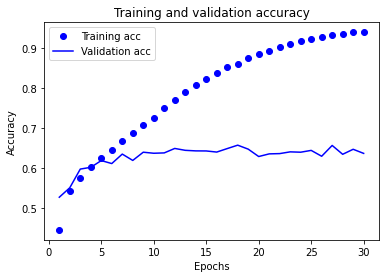

In [ ]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
MODEL_FILE_NAME = 'fer2013VGGTransferFinal.h5'
model.save(MODEL_FILE_NAME)

## Integrated Gradients

This part will demonstrate the use of integrated gradients for image classification tasks.

First install the package for integrated gradients.

Check the package usage in [here](https://docs.seldon.io/projects/alibi/en/latest/methods/IntegratedGradients.html).

In [ ]:
pip install alibi

In [ ]:
from alibi.explainers import IntegratedGradients ## load the package

Load the model trained by the transfer model described above.

We already trained this model and saved it (so you can directly use this model to save the time).

In [ ]:
if exists('/content/fer2013VGGTransferFinal0303.h5') == False:
    !wget -q -P ./ https://www.dropbox.com/s/vjjwg2u71mnm362/fer2013VGGTransferFinal0303.h5

In [ ]:
model = tf.keras.models.load_model('/content/fer2013VGGTransferFinal0303.h5')

Load the pictures we want to test

In [ ]:
if exists('/content/Picture1.jpg') == False:
    !wget -q -P ./ https://www.dropbox.com/s/ddocf4ltklj3zie/Picture1.jpg
    !wget -q -P ./ https://www.dropbox.com/s/877fd0obvq078oj/Picture2.jpg
    !wget -q -P ./ https://www.dropbox.com/s/q3089z8np9uchxy/Picture3.jpg
    !wget -q -P ./ https://www.dropbox.com/s/zqhnm4ddotlzg05/Picture4.jpg

Take a look for the fun pictures!

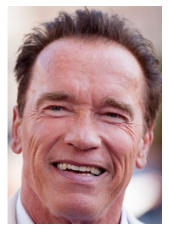

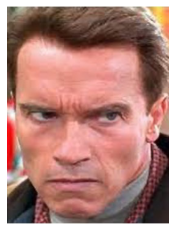

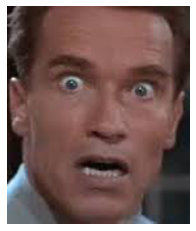

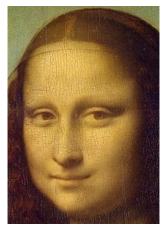

In [ ]:
file_name = '/content/Picture'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

files = []
for i in range(1,5):
    img = Image.open(file_name + str(i) + ".jpg") 
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    files.append(np.asarray(img.resize((48, 48)))) ##resize the image for the model input

files = np.asarray(files)

What is our model prediction?

In [ ]:
predictions = model(files).numpy().argmax(axis=1)

for predict in predictions:
    print(emotions_names[predict])

happy
angry
fear
neutral


Seems good!

Create an integrated gradient object based on the model

In [ ]:
ig  = IntegratedGradients(model)

Using integrated gradient to explain the predictions

In [ ]:
explanation = ig.explain(files,
                         target=predictions)

attrs = explanation.attributions[0]

attrs consists of 4 pictures.

each element of attrs is (48, 48, 3), representing the importance score for each pixel of the corresponding picture

In [ ]:
print(attrs.shape)

(4, 48, 48, 3)


We plot the figure that highlights the areas where the absolute value of the importance score is significantly large (white marks the area that is not important) 

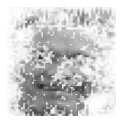

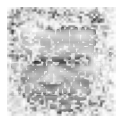

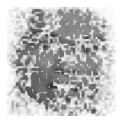

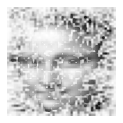

In [ ]:
cmap_bound = np.abs(attrs).max()
for row, image_id in enumerate(range(4)):
    x = int(row / 2)
    y = row % 2

    # attributions
    attr = attrs[image_id]    

    plt.figure(figsize=(2, 2))


    ## we plot the figure that highlights the areas where the absolute value of the importance score is significantly large
    plt.imshow(files[image_id].mean(axis=2), cmap='gray', alpha=np.sum(np.abs(attr),axis=2) / np.sum(np.abs(attr),axis=2).max() * 10)

    plt.axis('off')
    plt.show()

Interesting! It seems like the model is looking at the whole face including forhead, eyebrow, face muscles, etc..